# Plotting Webs

In [8]:
using Pkg
using Revise

Pkg.activate("..")

using CairoMakie, GeometryBasics
using NetworkLayout
using GraphMakie, Graphs, MetaGraphs
using ColorSchemes

using FoodWebs
fw = FoodWebs
using LinearAlgebra
using StatsBase, Polynomials, Random, Distributions
using JLD2
using UUIDs

  Activating project at `~/Projects/Working/HIFMB/TempRanges`


In [9]:
function exp_parameters(N::Int64, M::Int64)
    #exponent
    γ = rand(Uniform(0.8, 1.5), N, M) #[0.8, 1.5]
    λ = ones(N,N) # 1
    μ = rand(Uniform(1.0, 2.0), N, M) #[1.0, 2.0] 
    ϕ = rand(Uniform(0.0, 1.0), N, M) #[0.0, 1.0]
    ψ = rand(Uniform(0.5,1.1), N, M) #[0.5, 1.2]

    return [fw.ExponentialParameters(γ[:,i], λ, μ[:,i], ϕ[:,i], ψ[:,i]) for i = 1:M]
end

#function to convert uniform RV to lonlat
function sample_lonlat(N)
    lat = range(0,1,length = N)
    tuple.(rand(N), asin.(lat))
end

sample_lonlat (generic function with 1 method)

In [28]:
# test simulation
loc = sample_lonlat(50)

#generate inital meta communiuty
mc_original = fw.stable_metacommunity(30,0.2,loc, fexp = exp_parameters, verbose = false, max_draws = 1000, vk = 1000, psw_threshold = 0.8)    

#disperse
mc_pos = deepcopy(mc_original)
fw.multiple_dispersal!(mc_pos, p_dispersal = :a, d_dispersal = :p, αd = 0.75, T_opt = 0.25)

mc_neg = deepcopy(mc_original)
fw.multiple_dispersal!(mc_neg, p_dispersal = :a, d_dispersal = :p, αd = -0.75, T_opt = 0.25)

In [29]:
#Metrics  
function get_shortestpath(g)
    prod = findall(g.gprops[:prod])
    src = 1:size(g)[1]
    
    d = Matrix{Any}(undef, length(src), length(prod))
    
    for i = eachindex(src)
        for j = eachindex(prod)
            d[i,j] = length(Graphs.a_star(g, src[i], prod[j]))
            d[i,j] = d[i,j] == 0 ? Inf : d[i,j]
            if i == prod[j]
                d[i,j] = 0
            end
        end

        if all(d[i,:] .== Inf)
            d[i,:] .= 1.0
        end
    end
    
    tl = (minimum(d,dims=2) .+ 1)[:]

    # return(tl ./ maximum(tl))
end

function get_TL(g)
    #calculate χ
    N = size(g)[1]
    A = adjacency_matrix(g)
    
    χ = A ./ (norm.(eachrow(A), 1))
    χ[isnan.(χ)] .= 0.0
    
    A = I(N) - χ'
    TL = ones(1, N) * inv(A) 
    return(TL[:])
end

get_TL (generic function with 1 method)

In [92]:
function bin_vec(x; min_val = minimum(x), max_val = maximum(x), nbins = 5)
    #get bin boundaries
    boundaries = range(min_val, max_val + 10eps(),length = nbins)

    #itterate through and get bins
    y = similar(x)
    for i = eachindex(x)
        y[i] = findfirst((x[i] .- boundaries) .<= 0)
    end

    return(y)
end

function space_bins(bins)
    bins_dict = Dict(k => 1 for k = unique(bins))
    x_pos = similar(bins)

    for i = eachindex(bins)
        x_pos[i] = bins_dict[bins[i]]
        bins_dict[bins[i]] += 1
    end

    #normalise in each group
    for g = unique(bins)
        indx = findall(bins .== g)
        x_pos[indx] .= (x_pos[indx] .- mean(x_pos[indx]))
    end

    return(x_pos)

end

space_bins (generic function with 1 method)

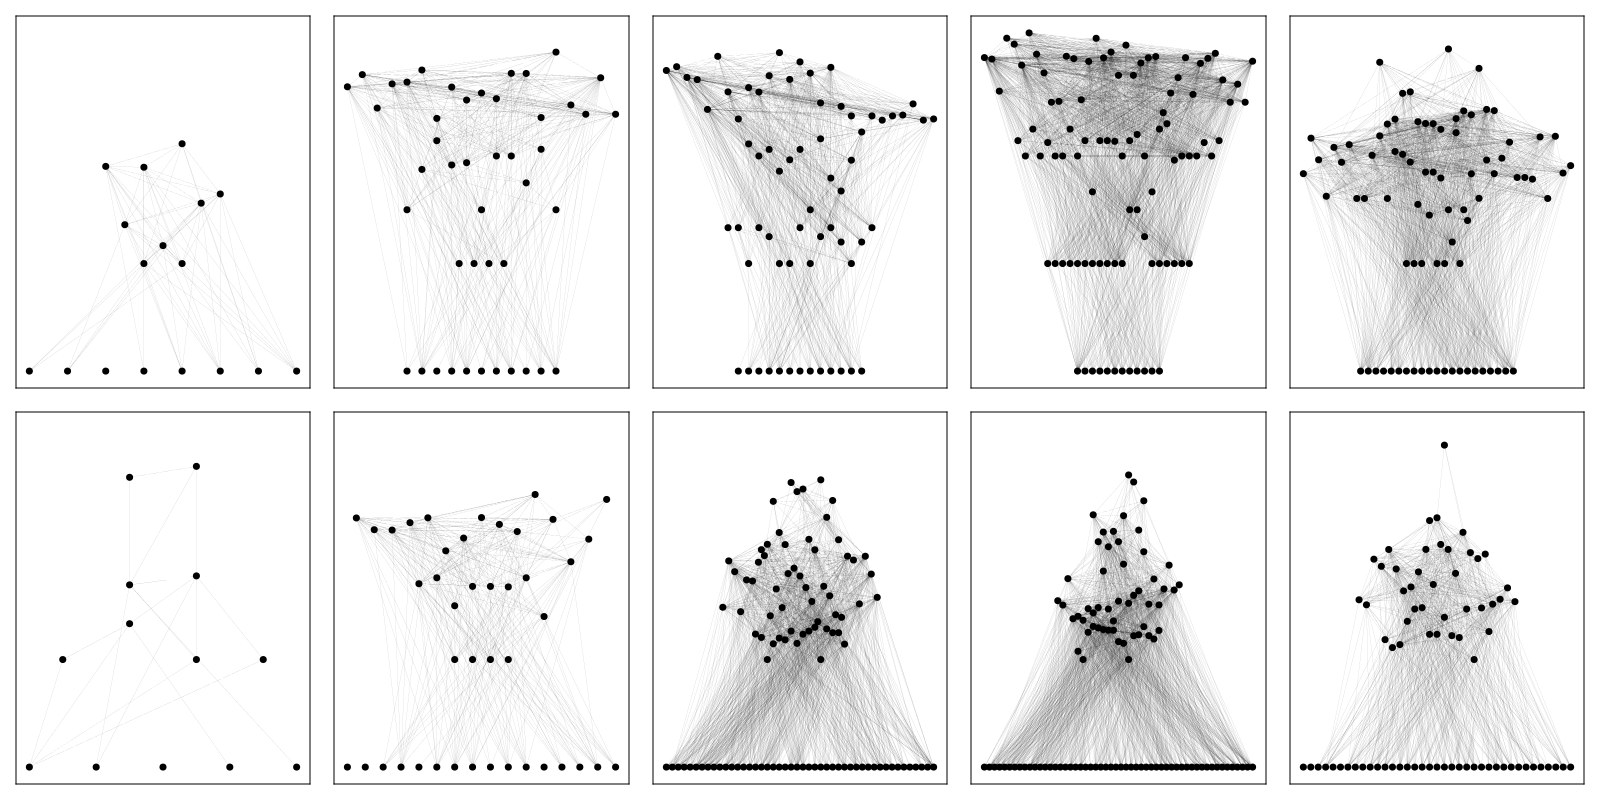

In [103]:
function foodweb_layout(g)
    # ny = rand(size(g)[1])
    # ny = get_shortestpath(g)
    ny = get_TL(g)
    
    #bin
    bin_n = bin_vec(ny)
    nx = space_bins(bin_n)
    
    # nx = g.gprops[:n]
    return(Point.(zip(nx, ny)))
end

#convert to graphs
ind = [5,15,25,35,45]

g_mat = Matrix{Any}(undef, 2, 5)
g_mat[1,:] .= [MetaDiGraph(SimpleDiGraph(mc_pos.coms[i].A)) for i = ind]
g_mat[2,:] .= [MetaDiGraph(SimpleDiGraph(mc_neg.coms[i].A)) for i = ind]

f = Figure(resolution = (1600, 800))

for t = 1:5
    ax = Axis(f[1,t])
    graphplot!(ax, g_mat[1,t], layout = foodweb_layout, edge_width = 0.05, arrow_size = 0, node_size = 10)

    ax = Axis(f[2,t])
    graphplot!(ax, g_mat[2,t], layout = foodweb_layout, edge_width = 0.05, arrow_size = 0, node_size = 10)
end
hidedecorations!.(f.content)
linkyaxes!(f.content...)
    
f

In [105]:
save("../Figures/netsci_exports/graphs.png", f)

CairoMakie.Screen{IMAGE}


In [ ]:
f = Figure()

ax1 = Axis(f[1,1])
prod = findall([x.producer[1] for x = mc.coms[end-1].sp])
node_color = [:black for i = 1:mc.coms[end-1].N]
node_color[prod] .= :green
graphplot!(ax1,g_vec[1], layout=foodweb_layout, edge_width = 0.3, arrow_size = 0, node_size = 10, node_color = node_color)

ax2 = Axis(f[1,2])
node_color = [:black for i = 1:com.N]

prod = findall([x.producer[1] for x = com.sp])
new_nodes = findall([x.Tpk != com.T for x = com.sp])

node_color[prod] .= :green
node_color[to_remove] .= :red
node_color[new_nodes] .= :blue
node_color[intersect(to_remove, new_nodes)] .= :pink
graphplot!(ax2,g_vec[2], layout=foodweb_layout, edge_width = 0.3, arrow_size = 0, node_size = 13, node_color = node_color)

ax3 = Axis(f[1,3])
graphplot!(ax3,g_vec[3], layout=foodweb_layout, edge_width = 0.3, arrow_size = 0.0, node_size = 5)

f